In [1]:
import numpy as np

CAMERAMATRIX = np.array([[  1.15730136e+03,   0.00000000e+00,   6.67042380e+02],
                        [  0.00000000e+00,   1.15270113e+03,   3.90488964e+02],
                        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
DISTORTIONCOEFFICIENTS = np.array([[ -2.38666546e-01,  -2.98287548e-02,  -5.14437800e-04,  -1.76570650e-04, -4.55111368e-02]])

print("CAMERAMATRIX:", CAMERAMATRIX, ", DISTORTIONCOEFFICIENTS:", DISTORTIONCOEFFICIENTS)


CAMERAMATRIX: [[  1.15730136e+03   0.00000000e+00   6.67042380e+02]
 [  0.00000000e+00   1.15270113e+03   3.90488964e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] , DISTORTIONCOEFFICIENTS: [[ -2.38666546e-01  -2.98287548e-02  -5.14437800e-04  -1.76570650e-04
   -4.55111368e-02]]


testImageNames: ['./test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']


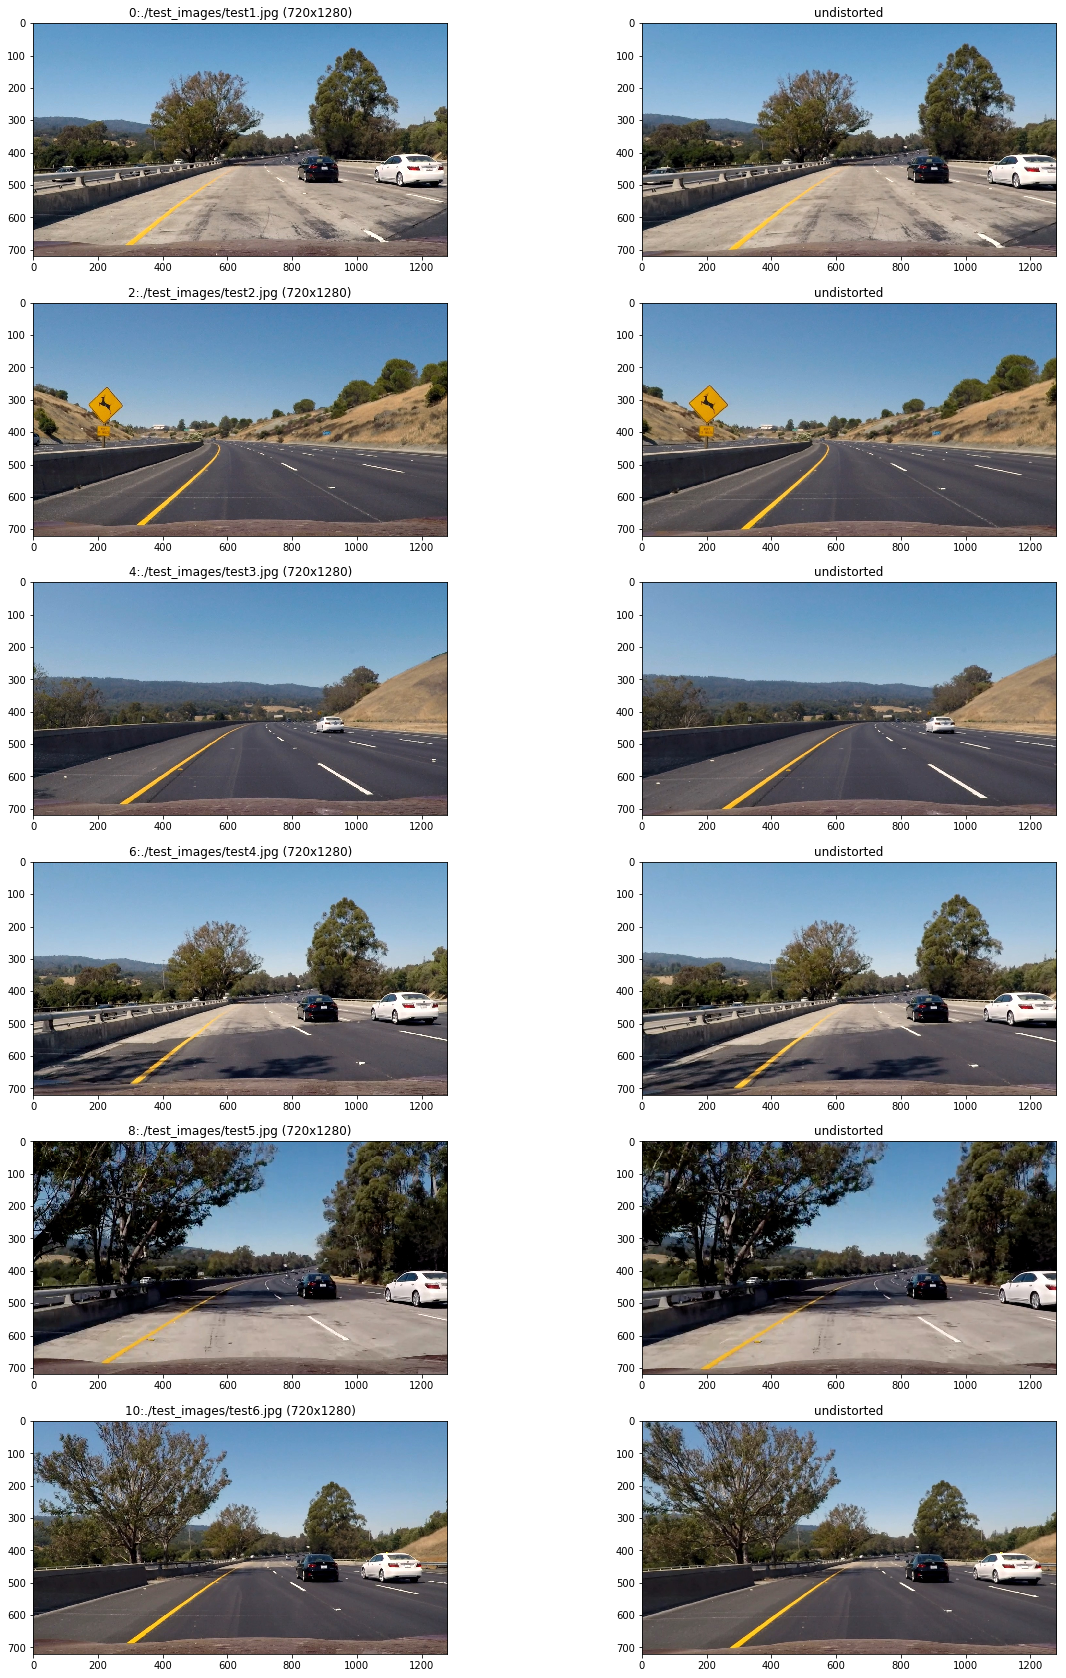

In [2]:
import cv2
import glob
import matplotlib.image as mpimage
import matplotlib.pyplot as plt

def undistortImage(rgbImage):
    undistortedImage = cv2.undistort(rgbImage, CAMERAMATRIX, DISTORTIONCOEFFICIENTS, None, CAMERAMATRIX)
    return undistortedImage

def showUndistortedImages(imageNames):
    FIGURECOLUMNCOUNT=2
    figureRowCount=len(imageNames)
    %matplotlib inline
    showImages = plt.figure(figsize = (FIGURECOLUMNCOUNT*10,figureRowCount*5))


    for imageIndex,rgbImageName in zip (range(0,FIGURECOLUMNCOUNT*figureRowCount,FIGURECOLUMNCOUNT), imageNames):
        #print("rgbImageName:", rgbImageName)
        rgbImage=mpimage.imread(rgbImageName)

        p=showImages.add_subplot(figureRowCount,FIGURECOLUMNCOUNT,imageIndex+1)
        p.set_title(str(imageIndex)+":"+rgbImageName+" ("+str(rgbImage.shape[0])+"x"+str(rgbImage.shape[1])+")")
        p.imshow(rgbImage)

        undistortedImage = undistortImage(rgbImage)
        p=showImages.add_subplot(figureRowCount,FIGURECOLUMNCOUNT,imageIndex+2)
        p.set_title("undistorted")
        p.imshow(undistortedImage)

testImageNames=glob.glob("./test_images/test*.jpg")
testImageNames.sort()
print("testImageNames:", testImageNames)

showUndistortedImages(testImageNames)

straightLineImageNames: ['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg']


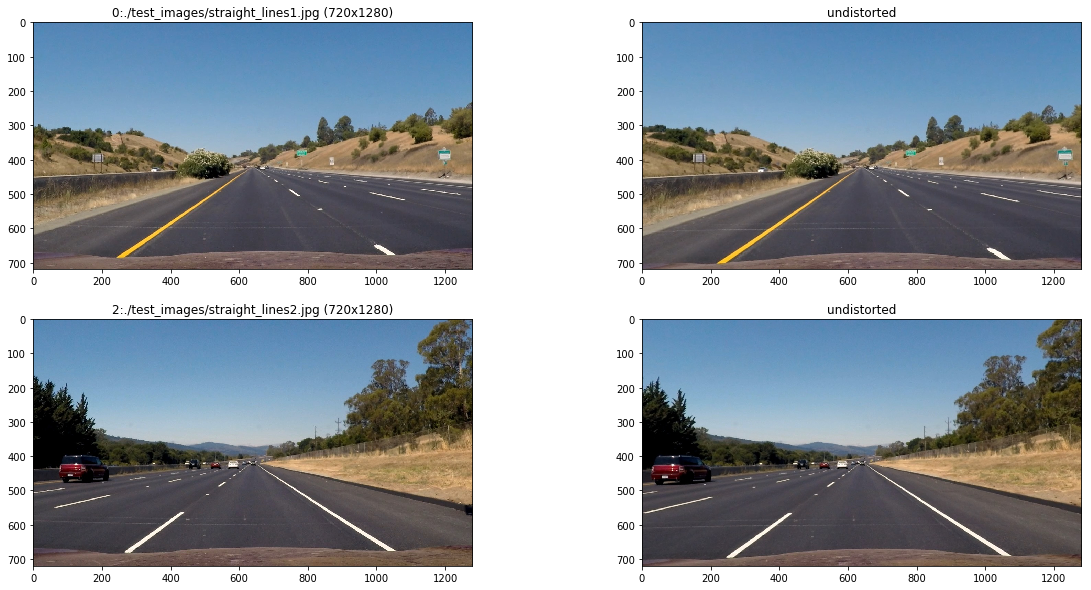

In [3]:
straightLineImageNames=glob.glob("./test_images/straight_lines*.jpg")
straightLineImageNames.sort()
print("straightLineImageNames:", straightLineImageNames)

showUndistortedImages(straightLineImageNames)

theRgbImage.shape: (720, 1280, 3)
croppedRgbImage.shape: (275, 1280, 3)
floodRoad-rgbImage.shape: (275, 1280, 3) , theSeedPoints: [(640, 265), (10, 264), (1269, 264)]
rgbImage.shape: (275, 1280, 3) , type: <class 'numpy.ndarray'>
roadMask.shape: (277, 1282)
roadMask.shape: (277, 1282)
createMaskedImage-image <class 'numpy.ndarray'> , image.shape: (275, 1280) , mask: <class 'numpy.ndarray'> , mask.shape: (277, 1282)
createMaskedImage-image <class 'numpy.ndarray'> , image.shape: (275, 1280) , compatibleMask: <class 'numpy.ndarray'> , compatibleMask.shape: (277, 1282)
drawLine-line - type: <class 'numpy.ndarray'> values: [[323 273 627  60]] , dtype: int32
drawLine-line - type: <class 'numpy.ndarray'> values: [[658  59 832 176]] , dtype: int32
laneIntersection: (642.90945890128046, 48.852912019826519) , rightHoughLineAsList: [[658, 59], [832, 176]] , leftHoughLineAsList: [[323, 273], [627, 60]]
drawLine-line - type: <class 'numpy.ndarray'> values: [[642  48 977 274]] , dtype: int64
drawLin

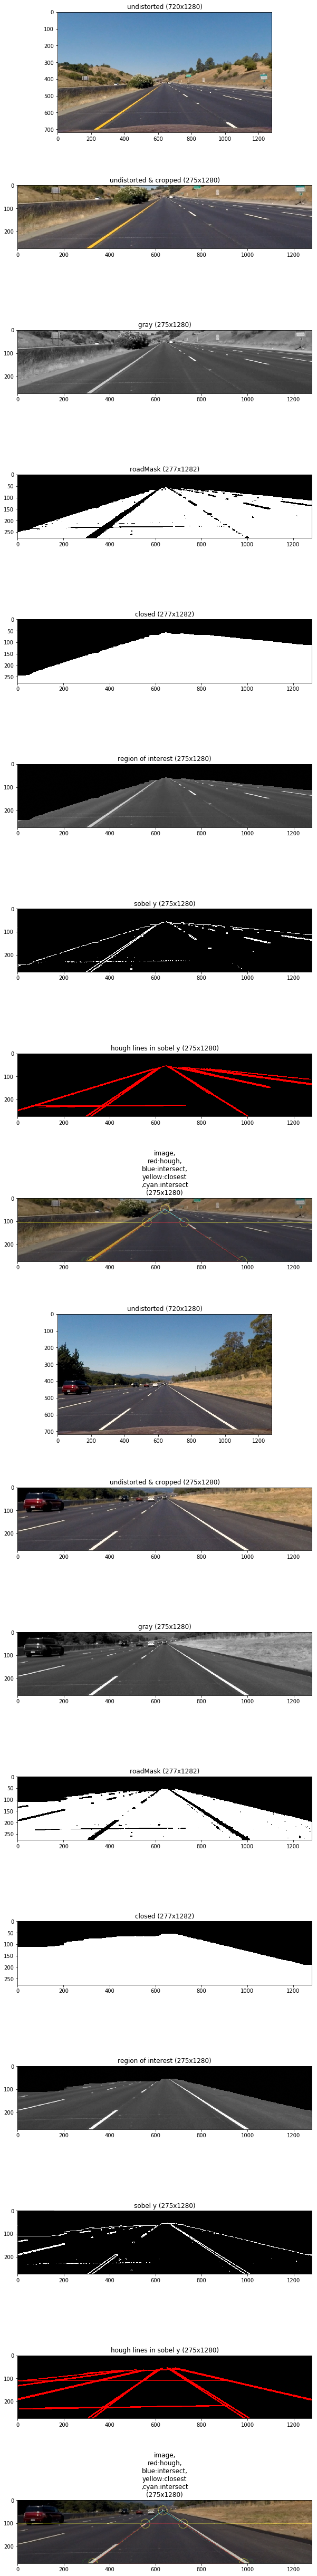

In [4]:
import cv2
import glob
import matplotlib.image as mpimage
import matplotlib.pyplot as plt

def scaleImage(image):
    #print("scaleImage-image.shape:", image.shape, ", type:", type(image))
    scaledImage = np.uint8(255.*image/float(np.max(image)))
    #print("scaleImage-counts:", np.unique(scaledImage, return_counts=True), ", shape:",scaledImage.shape)
    return scaledImage
    
def hls(rgbImage):
    hlsImage = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2HLS)
    #print("hls-hlsImage.shape:", hlsImage.shape, ", type:", type(hlsImage))
    h=hlsImage[:,:,0]
    #print("hls-h counts:", np.unique(h, return_counts=True), ", shape:",h.shape)
    h = scaleImage(h)
    #print("hls-scaled h counts:", np.unique(h, return_counts=True), ", shape:",h.shape)
    l = scaleImage(hlsImage[:,:,1])
    s = scaleImage(hlsImage[:,:,2])
    return h,l,s

def doConvertToGray(rgbImage):
    print("rgbImage.shape:", rgbImage.shape, ", type:", type(rgbImage))
    return cv2.cvtColor(rgbImage, cv2.COLOR_RGB2GRAY)

BLURKERNELSIZE = 5
def doBlur(image):
    blurred = cv2.GaussianBlur(image,(BLURKERNELSIZE, BLURKERNELSIZE), 0)
    return blurred

MASKFILLVALUE = 0;
CONNECTIVITY = 4 # 4 way
def floodRoad(rgbImage, theSeedPoints):
    print("floodRoad-rgbImage.shape:", rgbImage.shape, ", theSeedPoints:", theSeedPoints)
    grayscaleImage=doConvertToGray(rgbImage.copy())
    blurredGrayImage = doBlur(grayscaleImage)
    imageWidth=blurredGrayImage.shape[1] # X
    imageHeight=blurredGrayImage.shape[0] # Y
    roadFlags = CONNECTIVITY | (MASKFILLVALUE << 1)
    # for gray scale image
    roadMask = np.zeros((imageHeight+2, imageWidth+2), np.uint8)
    #print('grayScale:', type(grayScale), 'with dimensions:', grayScale.shape, 'road flags: <', hex(roadFlags), '>, theSeedPoints:', theSeedPoints)
    for seedPoint in theSeedPoints:
        #print('seedPoint:', seedPoint," type: ", type(seedPoint)) 
        #print('road seed color:', grayScale[seedPoint[1], seedPoint[0]]," at ", seedPoint) 
        cv2.floodFill(blurredGrayImage, roadMask, seedPoint, 255, 1, 1, roadFlags)
    return grayscaleImage, roadMask

DIALATEKERNELSIZE=5
def closeFloodedRegions(image):
    kernel = np.ones((DIALATEKERNELSIZE,DIALATEKERNELSIZE),np.uint8)
    dialatedImage=cv2.dilate(image.copy(), kernel, iterations=7)
    dialatedImage=cv2.erode(dialatedImage, kernel, iterations=7)
    imageWidth=dialatedImage.shape[1] # X
    imageHeight=dialatedImage.shape[0] # Y
    #lostPixels=int(DIALATEKERNELSIZE/2)
    #print("lostPixels:",lostPixels, ", DIALATEKERNELSIZE:", DIALATEKERNELSIZE, ". dialatedImage.shape", dialatedImage.shape)
    #return dialatedImage[lostPixels:imageHeight-lostPixels, lostPixels:imageWidth-lostPixels]
    return dialatedImage

def createMaskedImage(image, mask):
    print('createMaskedImage-image', type(image), ', image.shape:', image.shape,
          ', mask:', type(mask), ', mask.shape:', mask.shape)
    #returning the image only where mask pixels are nonzero
    imageWidth=image.shape[1] # X
    imageHeight=image.shape[0] # Y
    maskedImage=image.copy()
    compatibleMask=mask.copy()[0:imageHeight,0:imageWidth] # mask is same size as image
    print('createMaskedImage-image', type(image), ', image.shape:', image.shape,
          ', compatibleMask:', type(mask), ', compatibleMask.shape:', mask.shape)
    cv2.bitwise_and(image, 1, maskedImage, compatibleMask)
    return maskedImage

def invertMask(mask):
    #cv2.threshold(src, thresh, maxval, type[, dst]) → retval, dst¶
    retval, invertedMask = cv2.threshold(255 - mask, 254, 1, cv2.THRESH_BINARY)
    return invertedMask

def findCannyEdges(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

def twoPointLineToLineList(line):
    #print("twoPointLineToLineList - line - type:", type(line), 'values:', line)
    x1=line[0][0]
    y1=line[0][1]
    x2=line[1][0]
    y2=line[1][1]
    return np.array([[x1, y1, x2, y2]])

def drawLine(img, line, color=[0, 0, 255], thickness=2):
    print("drawLine-line - type:", type(line), 'values:', line, ", dtype:", line.dtype)
    x1=int(line[0,0])
    y1=int(line[0,1])
    x2=int(line[0,2])
    y2=int(line[0,3])
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def drawLines(image, lines, lineColor=[255, 0, 0], lineThickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), lineColor, lineThickness)

def drawTrapezoid(theImage, theTrapezoid, lineColor=[255, 0, 0], lineThickness=2):
    for point in range(len(theTrapezoid)):
        x1=theTrapezoid[point][0]
        y1=theTrapezoid[point][1]
        x2=theTrapezoid[(point+1)%len(theTrapezoid)][0]
        y2=theTrapezoid[(point+1)%len(theTrapezoid)][1]
        print("drawTrapezoid - x1:", x1, ", y1:", y1,", x2:", x2, ", y2:", y2)
        drawLine(theImage, np.array([[x1, y1, x2, y2]]), lineColor, lineThickness)

def findHoughLines(image, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    #Python: cv2.HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]]) → lines
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    drawLines(line_img, lines)
    return lines, line_img

def abs_sobel_thresh(grayImage, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient=='x':
        sobel = cv2.Sobel(grayImage, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(grayImage, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    absSobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaledSobel = np.uint8(255*absSobel/np.max(absSobel))
    #print("abs_sobel_thresh-orient:", orient,", counts:", np.unique(scaledSobel, return_counts=True), ", shape:",scaledSobel.shape)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    scaledSobelBinary = np.zeros_like(scaledSobel)
    #print("abs_sobel_thresh-orient:", orient,", counts:", np.unique(scaledSobelBinary, return_counts=True), ", shape:",scaledSobelBinary.shape)
    scaledSobelBinary[(scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1])] = 1
    #print("abs_sobel_thresh-orient:", orient,", counts:", np.unique(scaledSobelBinary, return_counts=True), ", shape:",scaledSobelBinary.shape)
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    #return binary_output
    #
    return scaledSobelBinary

def getLineCoefficients(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersectLineCoefficients(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

def intersectLines(line1, line2):
    #print("line1 - type:", type(line1), 'values:', line1)
    #print("line2 - type:", type(line2), 'values:', line2)
    L1 = getLineCoefficients(line1[0], line1[1])
    L2 = getLineCoefficients(line2[0], line2[1])

    R = intersectLineCoefficients(L1, L2)
    #print ("intesecting - line1:", line1, " and line2:", line2, "gives R:", R)
    if R:
        return R
    else:
        #print ("No single intersection point detected, line1: <",line1,">, line2: <",line2,">")
        return False

def intersectHoughLines(theHoughLines, theBaseLine):
    #print("theHoughLines - type:", type(theHoughLines), 'shape:', theHoughLines.shape, 'values:', theHoughLines)
    #print("theBaseLine - type:", type(theBaseLine), 'shape:', theBaseLine.shape, 'values:', theBaseLine)
    intersections=np.zeros((theHoughLines.shape[0],4), dtype=np.int32)
    #print("intersection[0] - type:", type(intersections[0]), 'value:', intersections[0])
    baseLineList=[[theBaseLine[0,0], theBaseLine[0,1]], [theBaseLine[1,0], theBaseLine[1,1]]]
    houghLineIndex=0
    for houghLine in theHoughLines:
        #print("houghLine[",houghLineIndex,"] - type:", type(houghLine), '=', houghLine)
        houghLineList=[[houghLine[0,0], houghLine[0,1]], [houghLine[0,2], houghLine[0,3]]]
        lineIntersecion=intersectLines(houghLineList, baseLineList)
        #print("lineIntersecion - type:", type(lineIntersecion), 'value:', lineIntersecion)
        if lineIntersecion:
            intersections[houghLineIndex]=[houghLineIndex, True, lineIntersecion[0], lineIntersecion[1]]
        else:
            intersections[houghLineIndex]=np.array([houghLineIndex, False, 0, 0])
        #print ("intersections[",houghLineIndex,"]:", intersections[houghLineIndex])
        houghLineIndex+=1
    return intersections

def findFirstIntersectionIndexToLeftofMarker(theIntersections, theMarker):
    foundFirstX=False
    firstX=0
    firstIntersectionIndex=0
    intersectionIndex=0
    for intersection in theIntersections:
        x=intersection[2]
        if (x <= theMarker):
            #print ("x:", x, ", theMarker:",theMarker)
            if (foundFirstX):
                if x>=firstX:
                    firstX=x
                    firstIntersectionIndex=intersectionIndex
                else:
                    pass
            else:
                foundFirstX=True
                firstX=x
                firstIntersectionIndex=intersectionIndex
        intersectionIndex+=1
        #print ("x:", x, ", foundFirstX:",foundFirstX,", intersectionIndex:",intersectionIndex, "firstX:", firstX, ", firstIntersectionIndex:", firstIntersectionIndex)
    if foundFirstX:
        return firstIntersectionIndex
    else:
        return False

def findFirstIntersectionIndexToRightofMarker(theIntersections, theMarker):
    foundFirstX=False
    firstX=0
    firstIntersectionIndex=0
    intersectionIndex=0
    for intersection in theIntersections:
        x=intersection[2]
        if (x >= theMarker):
            #print ("x:", x, ", theMarker:",theMarker)
            if (foundFirstX):
                if x <= firstX:
                    firstX=x
                    firstIntersectionIndex=intersectionIndex
                else:
                    pass
            else:
                foundFirstX=True
                firstX=x
                firstIntersectionIndex=intersectionIndex
        intersectionIndex+=1
        #print ("x:", x, ", foundFirstX:",foundFirstX,", intersectionIndex:",intersectionIndex, "firstX:", firstX, ", firstIntersectionIndex:", firstIntersectionIndex)
    if foundFirstX:
        return firstIntersectionIndex
    else:
        return False
    
def combineImages(img, initial_img, α=0.8, λ=0.):
    #print ("img.shape:", img.shape, ", initial_img.shape:", initial_img.shape)
    return cv2.addWeighted(initial_img, α, img, 1.-α, λ)

def drawIntersectionOnImage(theImage, theIntersection, theColor=[0, 0, 255], theThickness=2):
    #print("drawIntersectionOnImage - theIntersection - type:", type(theIntersection), 'values:', theIntersection)
    x=int(theIntersection[0])
    y=int(theIntersection[1])
    cv2.circle(theImage, (x,y), 20, theColor, theThickness)

def getHoughIntersectionPoint(theHoughIntersection):
    x=int(theHoughIntersection[2])
    y=int(theHoughIntersection[3])
    return np.array([x,y])

def drawHoughIntersectionOnImage(theImage, theHoughIntersection, theColor=[0, 0, 255], theThickness=2):
    #print("drawHoughIntersectionOnImage - theHoughIntersection - type:", type(theHoughIntersection), 'values:', theHoughIntersection)
    #x=theHoughIntersection[2]
    #y=theHoughIntersection[3]
    drawIntersectionOnImage(theImage, getHoughIntersectionPoint(theHoughIntersection), theColor, theThickness)

def drawHoughIntersectionsOnImage(theImage, theIntersections, theColor=[0, 255, 0], theThickness=1, α=0.8):
    #intersectionsImage=np.zeros_like(theImage, dtype=np.float)
    intersectionsImage=np.zeros_like(theImage)
    #print("theImage.shape:",theImage.shape, ", intersectionsImage.shape:", intersectionsImage.shape)
    for intersection in theIntersections:
        #print("intersection - type:", type(intersection), 'shape:', intersection.shape, 'values:', intersection)
        drawHoughIntersectionOnImage(intersectionsImage, intersection, theColor, theThickness)
    #print("intersectionsImage.shape:", intersectionsImage.shape, ", intersectionsImage.dtype:", intersectionsImage.dtype)
    #p=showImages.add_subplot(figureRowCount,figureColumnCount,9)
    #p.set_title("testing drawHoughIntersectionsOnImage ("+str(combinedImage.shape[0])+"x"+str(combinedImage.shape[1])+")")
    #p.imshow(intersectionsImage)
    return combineImages(intersectionsImage, theImage,  α)

def findFourPointsOnLaneMarkers(theRgbImage, showImages, imageRows, imageColumns, imageIndex):
    
    print("theRgbImage.shape:", theRgbImage.shape)
    imageWidth=theRgbImage.shape[1] # X
    imageHeight=theRgbImage.shape[0] # Y

    undistortedRgbImage = cv2.undistort(theRgbImage, CAMERAMATRIX, DISTORTIONCOEFFICIENTS, None, CAMERAMATRIX)
    p=showImages.add_subplot(imageRows,imageColumns, imageIndex+1)
    p.set_title("undistorted ("+str(imageHeight)+"x"+str(imageWidth)+")")
    p.imshow(undistortedRgbImage)

    croppedRgbImage = undistortedRgbImage[375:650, 0:imageWidth] # Crop from x, y, w, h -> 100, 200, 300, 400
    print("croppedRgbImage.shape:", croppedRgbImage.shape)
    croppedImageWidth=croppedRgbImage.shape[1] # X
    croppedImageHeight=croppedRgbImage.shape[0] # Y
    p=showImages.add_subplot(imageRows,imageColumns, imageIndex+2)
    p.set_title("undistorted & cropped ("+str(croppedImageHeight)+"x"+str(croppedImageWidth)+")")
    p.imshow(croppedRgbImage)

    roadSeedPoints = [(int(croppedImageWidth/2),int(croppedImageHeight-10)),(0+10, croppedImageHeight-1-10), (croppedImageWidth-1-10, croppedImageHeight-1-10)]
    grayscaleImage, roadMask = floodRoad(croppedRgbImage, roadSeedPoints)
    print("roadMask.shape:", roadMask.shape)
    p=showImages.add_subplot(imageRows,imageColumns, imageIndex+3)
    p.set_title("gray ("+str(grayscaleImage.shape[0])+"x"+str(grayscaleImage.shape[1])+")")
    p.imshow(grayscaleImage, cmap='gray')
    print("roadMask.shape:", roadMask.shape)
    p=showImages.add_subplot(imageRows,imageColumns, imageIndex+4)
    p.set_title("roadMask ("+str(roadMask.shape[0])+"x"+str(roadMask.shape[1])+")")
    p.imshow(roadMask, cmap='gray')

    regionOfInterest=closeFloodedRegions(roadMask)
    p=showImages.add_subplot(imageRows,imageColumns, imageIndex+5)
    p.set_title("closed ("+str(regionOfInterest.shape[0])+"x"+str(regionOfInterest.shape[1])+")")
    p.imshow(regionOfInterest, cmap='gray')

    regionOfInterest = invertMask(regionOfInterest)
    _,lightness,_ = hls(croppedRgbImage)
    regionOfInterestImage = createMaskedImage(grayscaleImage, regionOfInterest)
    p=showImages.add_subplot(imageRows,imageColumns, imageIndex+6)
    p.set_title("region of interest ("+str(regionOfInterestImage.shape[0])+"x"+str(regionOfInterestImage.shape[1])+")")
    p.imshow(regionOfInterestImage, cmap='gray')

    regionOfInterestImageWidth=regionOfInterestImage.shape[1]
    regionOfInterestImageHeight=regionOfInterestImage.shape[0]

    sobelImage=abs_sobel_thresh(regionOfInterestImage, orient='y', sobel_kernel=3, thresh=(20, 255))
    p=showImages.add_subplot(imageRows,imageColumns, imageIndex+7)
    p.set_title("sobel y ("+str(sobelImage.shape[0])+"x"+str(sobelImage.shape[1])+")")
    p.imshow(sobelImage, cmap='gray')

    houghLines, houghLineImage=findHoughLines(sobelImage, 1, np.pi/180, 40, 1, 400)
    p=showImages.add_subplot(imageRows,imageColumns, imageIndex+8)
    p.set_title("hough lines in sobel y ("+str(houghLineImage.shape[0])+"x"+str(houghLineImage.shape[1])+")")
    p.imshow(houghLineImage, cmap='gray')

    imageDecorations=np.zeros_like(croppedRgbImage)

    sobelImageHeight=sobelImage.shape[0]
    sobelImageWidth=sobelImage.shape[1]

    imageBaseLine = np.array([[0, sobelImageHeight-1], [sobelImageWidth-1, sobelImageHeight-1]])
    flattenedBaseLine = np.array([[imageBaseLine[0,0], imageBaseLine[0,1], imageBaseLine[1,0], imageBaseLine[1,1]]])
    houghLineIntersections=intersectHoughLines(houghLines,imageBaseLine)
    #print ("houghLineIntersections:", houghLineIntersections)
    houghLinesIntersectingBaseline = [houghLineIntersection
                                      for houghLineIntersection in houghLineIntersections
                                      if houghLineIntersection[1]>0 & houghLineIntersection[2]>=0
                                      & houghLineIntersection[3]<=regionOfInterestImageWidth ]
    #print ("houghLinesIntersectingBaseline:", houghLinesIntersectingBaseline)
    imageDecorations=drawHoughIntersectionsOnImage(imageDecorations, houghLinesIntersectingBaseline, α=0.7)

    firstIntersectionIndexToLeftofCenterline = findFirstIntersectionIndexToLeftofMarker(houghLinesIntersectingBaseline, sobelImageWidth/2)
    #print ("firstIntersectionIndexToLeftofCenterline:", firstIntersectionIndexToLeftofCenterline)
    #print ("firstIntersectionIndexToLeftofCenterline:", firstIntersectionIndexToLeftofCenterline, "houghLinesIntersectingBaseline[",firstIntersectionIndexToLeftofCenterline,"]:",houghLinesIntersectingBaseline[firstIntersectionIndexToLeftofCenterline])
    leftHoughLineIntersectingBaseline=houghLinesIntersectingBaseline[firstIntersectionIndexToLeftofCenterline]
    leftHoughLineIndex=leftHoughLineIntersectingBaseline[0]
    leftHoughLine=houghLines[leftHoughLineIndex]
    #print ("leftHoughLineIndex:", leftHoughLineIndex, ", houghLines[", leftHoughLineIndex, "]:", houghLines[leftHoughLineIndex])
    drawHoughIntersectionOnImage(imageDecorations, leftHoughLineIntersectingBaseline, (255,255,0))
    drawLine(imageDecorations, houghLines[leftHoughLineIndex], (255,255,0))


    firstIntersectionIndexToRightofCenterline = findFirstIntersectionIndexToRightofMarker(houghLinesIntersectingBaseline, sobelImageWidth/2)
    #print ("firstIntersectionIndexToRightofCenterline:", firstIntersectionIndexToRightofCenterline, "houghLinesIntersectingBaseline[",firstIntersectionIndexToRightofCenterline,"]:",houghLinesIntersectingBaseline[firstIntersectionIndexToRightofCenterline])
    rightHoughLineIntersectingBaseline=houghLinesIntersectingBaseline[firstIntersectionIndexToRightofCenterline]
    rightHoughLineIndex=rightHoughLineIntersectingBaseline[0]
    rightHoughLine=houghLines[rightHoughLineIndex]
    #print ("rightHoughLineIndex:", rightHoughLineIndex, ", houghLines[", rightHoughLineIndex, "]:", houghLines[rightHoughLineIndex])
    #print ("rightHoughLine:", rightHoughLine, ", leftHoughLine:", leftHoughLine)
    drawHoughIntersectionOnImage(imageDecorations, rightHoughLineIntersectingBaseline, (255,255,0))
    drawLine(imageDecorations, houghLines[rightHoughLineIndex], (255,255,0))

    # houghLineAsList has increasing X, line is left to right
    rightHoughLineAsList=[[rightHoughLine[0,0], rightHoughLine[0,1]], [rightHoughLine[0,2],rightHoughLine[0,3]]]
    leftHoughLineAsList=[[leftHoughLine[0,0], leftHoughLine[0,1]], [leftHoughLine[0,2],leftHoughLine[0,3]]]
    #print ("rightHoughLineAsList:",rightHoughLineAsList,", leftHoughLineAsList:",leftHoughLineAsList)
    laneIntersection=intersectLines(rightHoughLineAsList, leftHoughLineAsList)
    print ("laneIntersection:", laneIntersection, ", rightHoughLineAsList:",rightHoughLineAsList,", leftHoughLineAsList:",leftHoughLineAsList)
    drawHoughIntersectionOnImage(imageDecorations, [0,0,int(laneIntersection[0]),int(laneIntersection[1])], (255,255,0))
    drawLine(imageDecorations, np.array([[int(laneIntersection[0]),int(laneIntersection[1]), rightHoughLineIntersectingBaseline[2],rightHoughLineIntersectingBaseline[3]]]), [0,255,255])
    drawLine(imageDecorations, np.array([[int(laneIntersection[0]),int(laneIntersection[1]), leftHoughLineIntersectingBaseline[2],leftHoughLineIntersectingBaseline[3]]]), [0,255,255])

    # 1 point: laneIntersection & 2 lines: rightHoughLineAsList, leftHoughLineAsList
    minY=min(rightHoughLineAsList[0][1], rightHoughLineAsList[1][1], leftHoughLineAsList[0][1], leftHoughLineAsList[1][1], laneIntersection[1])
    maxY=imageDecorations.shape[0] # bottom of the image, stored row/column: Y,X
    topOfTrapezoidY=minY+.25*(maxY-minY)
    topOfTrapezoidAsList=[[0, topOfTrapezoidY], # point on left side of image at top of trapezoid (X=0)
                          [imageDecorations.shape[1], topOfTrapezoidY]] # point on right side of image at top of trapezoid (X=right side of image)
    print ("minY:", minY, ", maxY:", maxY, ", topOfTrapezoidY:", topOfTrapezoidY, ", topOfTrapezoidAsList:", topOfTrapezoidAsList)
    drawLine(imageDecorations, twoPointLineToLineList(topOfTrapezoidAsList), (255,255,0))

    topOfLeftHoughLine=intersectLines(topOfTrapezoidAsList, leftHoughLineAsList)
    print ("topOfLeftHoughLine:", topOfLeftHoughLine, "topOfTrapezoidAsList:", topOfTrapezoidAsList, ", leftHoughLineAsList:", leftHoughLineAsList)
    drawIntersectionOnImage(imageDecorations, topOfLeftHoughLine, (255,255,0))
    topOfRightHoughLine=intersectLines(topOfTrapezoidAsList, rightHoughLineAsList)
    print ("topOfRightHoughLine:", topOfRightHoughLine, "topOfTrapezoidAsList:", topOfTrapezoidAsList, ", rightHoughLineAsList:", rightHoughLineAsList)
    drawIntersectionOnImage(imageDecorations, topOfRightHoughLine, (255,255,0))
    trapezoidAsList=np.array([getHoughIntersectionPoint(leftHoughLineIntersectingBaseline),
                              [topOfLeftHoughLine[0], topOfLeftHoughLine[1]],
                              [topOfRightHoughLine[0],topOfRightHoughLine[1]],
                              getHoughIntersectionPoint(rightHoughLineIntersectingBaseline)],np.float32)
    print ("trapezoidAsList:", trapezoidAsList, ", topOfLeftHoughLine:", topOfLeftHoughLine, ", topOfRightHoughLine:", topOfRightHoughLine)
    drawTrapezoid(imageDecorations, trapezoidAsList, lineThickness=2)

    combinedImage=combineImages(imageDecorations, croppedRgbImage, α=0.75);
    print ("combinedImage.shape:", combinedImage.shape)

    p=showImages.add_subplot(imageRows,imageColumns, imageIndex+9)
    p.set_title("image,\nred:hough,\nblue:intersect,\nyellow:closest\n,cyan:intersect\n("+str(combinedImage.shape[0])+"x"+str(combinedImage.shape[1])+")")
    p.imshow(combinedImage)
    return trapezoidAsList, croppedRgbImage


import glob
rgbImageNames=glob.glob("./test_images/straight_lines*.jpg")
trapezoids={}
croppedRgbImages={}

testImageColumnCount=1
testImageRowCount=9*len(rgbImageNames) # undistorted, cropped, gray, roadMask, dialated, region of interest, canny edges, hough lines
%matplotlib inline
showTestImages = plt.figure(figsize = (testImageColumnCount*10,testImageRowCount*5))

for rgbImageName, testImageOffset in zip(rgbImageNames, range(len(rgbImageNames))):
    rgbImage=mpimage.imread(rgbImageName)
    trapezoid, croppedRgbImage=findFourPointsOnLaneMarkers(rgbImage, showTestImages, testImageRowCount, testImageColumnCount, testImageOffset*9)
    print ("trapezoid:", trapezoid)
    trapezoids[rgbImageName]=trapezoid
    croppedRgbImages[rgbImageName]=croppedRgbImage

print ("trapezoids:", trapezoids)



trapezoids: {'./test_images/straight_lines2.jpg': array([[ 328.        ,  274.        ],
       [ 556.40783691,  102.58548737],
       [ 721.34277344,  102.58548737],
       [ 985.        ,  274.        ]], dtype=float32), './test_images/straight_lines1.jpg': array([[ 321.        ,  274.        ],
       [ 562.21850586,  105.38968658],
       [ 726.98980713,  105.38968658],
       [ 977.        ,  274.        ]], dtype=float32)} , imageIndexRange: range(0, 4, 2)
trapezoid: [[ 328.          274.        ]
 [ 556.40783691  102.58548737]
 [ 721.34277344  102.58548737]
 [ 985.          274.        ]] , targetTrapezoid: [[ 328.          822.        ]
 [ 328.          307.75646973]
 [ 985.          307.75646973]
 [ 985.          822.        ]]
perspectiveTransform: [[ -5.07146013e+00  -1.40256868e+01   3.84303818e+03]
 [ -1.11022302e-15  -2.20338368e+01   1.86853106e+03]
 [ -4.33680869e-18  -2.21586136e-02   1.00000000e+00]]
targetImageSize: (1280, 825)
trapezoid: [[ 321.          274.       

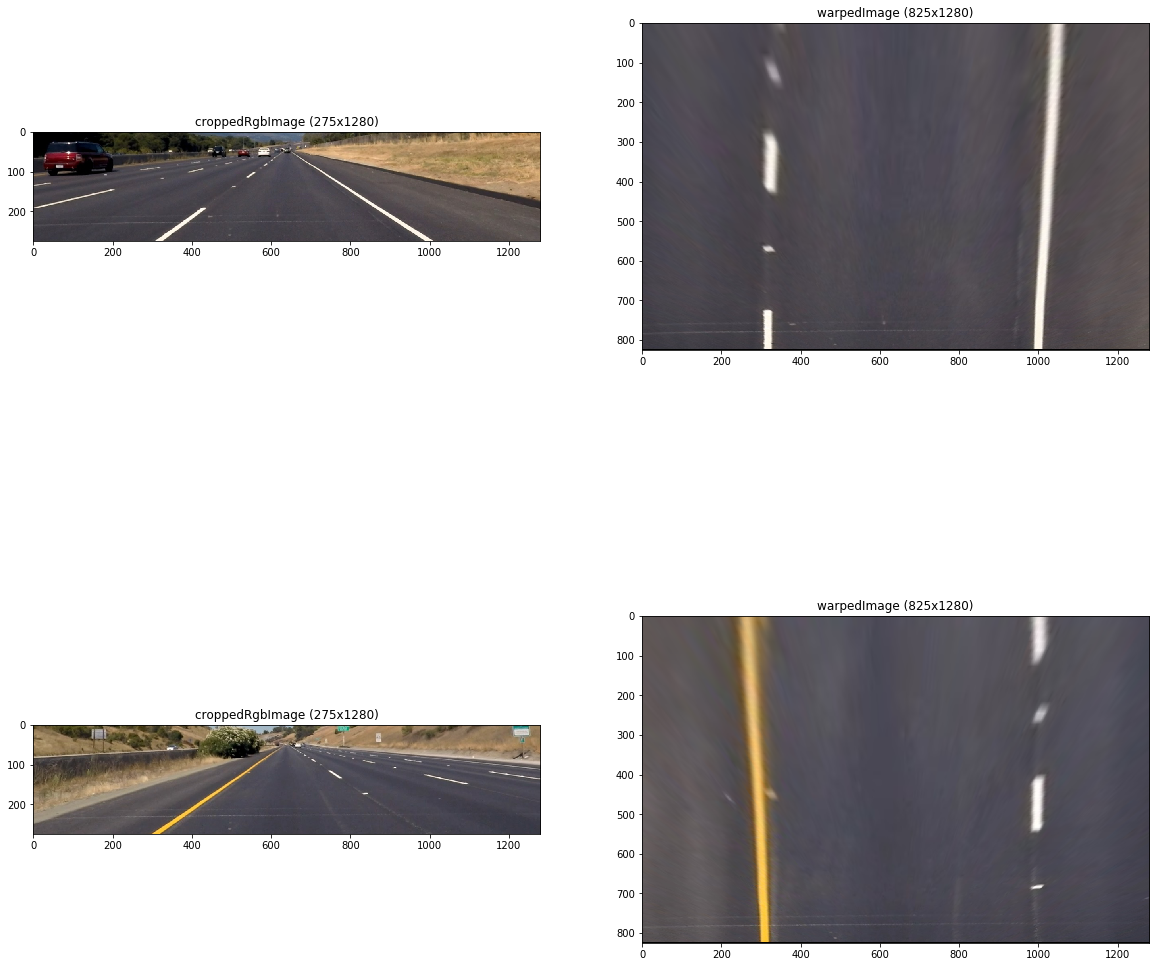

In [5]:
#baselineDistanceBetweenLaneMarkers=getHoughIntersectionPoint(rightHoughLineIntersectingBaseline)[0]-getHoughIntersectionPoint(leftHoughLineIntersectingBaseline)[0]
#print("baselineDistanceBetweenLaneMarkers:", baselineDistanceBetweenLaneMarkers)

SCALEX=1
SCALEY=3

def makePerspectiveTransform(trapezoid, croppedRgbImage):
    targetTrapezoid=np.array([[SCALEX*trapezoid[0][0], SCALEY*trapezoid[0][1]],
                              [SCALEX*trapezoid[0][0], SCALEY*trapezoid[1][1]],
                              [SCALEX*trapezoid[3][0], SCALEY*trapezoid[2][1]],
                              [SCALEX*trapezoid[3][0], SCALEY*trapezoid[3][1]]],np.float32)
    print ("trapezoid:", trapezoid, ", targetTrapezoid:", targetTrapezoid)
    perspectiveTransform=cv2.getPerspectiveTransform(trapezoid, targetTrapezoid)
    return perspectiveTransform

warpedFigureColumnCount=2 # unwarped, warped
warpedFigureRowCount=len(trapezoids)
%matplotlib inline
showWarpedImages = plt.figure(figsize = (warpedFigureColumnCount*10,warpedFigureRowCount*10))

perspectiveTransforms={}


imageIndexRange=range(0, warpedFigureRowCount*warpedFigureColumnCount, warpedFigureColumnCount)
print ("trapezoids:", trapezoids, ", imageIndexRange:", imageIndexRange)

for rgbImageName,imageIndex in zip(trapezoids, imageIndexRange):
    croppedRgbImage = croppedRgbImages[rgbImageName]
    p=showWarpedImages.add_subplot(warpedFigureRowCount,warpedFigureColumnCount,imageIndex+1)
    p.set_title("croppedRgbImage ("+str(croppedRgbImage.shape[0])+"x"+str(croppedRgbImage.shape[1])+")")
    p.imshow(croppedRgbImage)
                                   
    trapezoid = trapezoids[rgbImageName]
    perspectiveTransform=makePerspectiveTransform(trapezoid, croppedRgbImage)
    print("perspectiveTransform:", perspectiveTransform)
    perspectiveTransforms[rgbImageName]=perspectiveTransform

    targetImageSize=(SCALEX*croppedRgbImage.shape[1], SCALEY*croppedRgbImage.shape[0])
    print("targetImageSize:", targetImageSize)
    warpedImage=cv2.warpPerspective(croppedRgbImage, perspectiveTransform, targetImageSize, flags=cv2.INTER_LINEAR)

    p=showWarpedImages.add_subplot(warpedFigureRowCount,warpedFigureColumnCount,imageIndex+2)
    p.set_title("warpedImage ("+str(warpedImage.shape[0])+"x"+str(warpedImage.shape[1])+")")
    p.imshow(warpedImage)

print("perspectiveTransforms:", perspectiveTransforms)

